## Import libraries

In [1]:

import os
from collections import defaultdict
import pickle
from pathlib import Path
from copy import deepcopy
from metaflow import Flow, Step
from sklearn.metrics import roc_auc_score,roc_curve
import pandas as pd
import numpy as np
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage, Grayscale
import torch
import scipy as sp
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from src.tree import SoftlabelTransform

from src.utils import CSVLogger, tensor2np, get_freer_gpu
from src.gda import GaussianDiscriminantAnalysis


## TSNE
### data preparation for TSNE

In [2]:
path = './testtime/derivative_objects_new_0221'

# Read pickle data from folder. In the pickle data, it include a dict of dicts. The first level keys are 4 left out classes
def get_logits_dict_data(model_type, path):
    # Load logits_dict depending on the model_type
    if model_type == 'flat':
        file_name = "logits_dict_flat_new.pkl"
    else:
        file_name = "logits_dict_hier_new.pkl"
    
    logits_dict_path = Path(path) / file_name
    print(logits_dict_path)
    with open(logits_dict_path, "rb") as f:
        logits_dict = pickle.load(f)
    
    all_experiments = {}
    for n, out in enumerate(logits_dict.keys()):
        my_dict = logits_dict[out]
        rows = []
        for key, arr_list in my_dict.items():
            for arr in arr_list:
                row = {'logits': arr, 'true_label': key}
                rows.append(row)
        df = pd.DataFrame(rows)
        all_experiments[out] = df
    
    return all_experiments

def prepare_data_TSNE(all_experiments,left_out):
    ligits_np =np.vstack(all_experiments[left_out]['logits'].to_numpy())
    label_list =np.squeeze(np.vstack(all_experiments[left_out]['true_label'].to_numpy()))
    return ligits_np, label_list

### Plot TSNE

In [3]:


le = LabelEncoder()

colors_map = ["pink", "blue", "green", "cyan", "purple", 
                       "lime", "red", "magenta", "brown", "yellow", "orange", "gray",  "black","dodgerblue"]
def TSNE_for_all(data,model_type):
    class_set = data.keys()
    for left_out in class_set:
        le = LabelEncoder()
        X,y = prepare_data_TSNE(data,left_out)
        colors = le.fit_transform(y)
        X_scaled = X
        label_colors = [colors_map[color] for color in colors]
        X_embedded = TSNE(n_components=2,random_state= 42)
        digitd_tsne = X_embedded.fit_transform(X_scaled)


        fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
        for i,label in enumerate(np.unique(y)):
            idx = np.where(y == label)
            maped_label = label
            ax.scatter(digitd_tsne[idx, 0], digitd_tsne[idx, 1], s =10,c= colors_map[i],label=maped_label)
        if left_out == 'A31' or left_out == 'A40':
            ax.legend(loc='upper right', bbox_to_anchor=(1.17, 1.0), fontsize='small')       
        maped_leftout = left_out  
        plt.title('TSNE_'+maped_leftout)
        if model_type == 'hier':
            plt.savefig(Path(path)/('TSNE/'+left_out+'_hier.png'),bbox_inches='tight')
        else:
            plt.savefig(Path(path)/('TSNE/'+left_out+'_flat.png'),bbox_inches='tight')
        plt.show()

testtime/derivative_objects_new_0221/logits_dict_hier_new.pkl


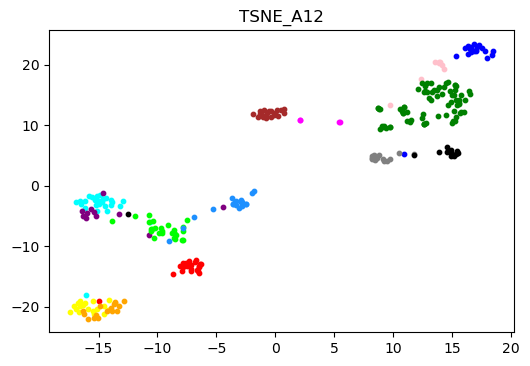

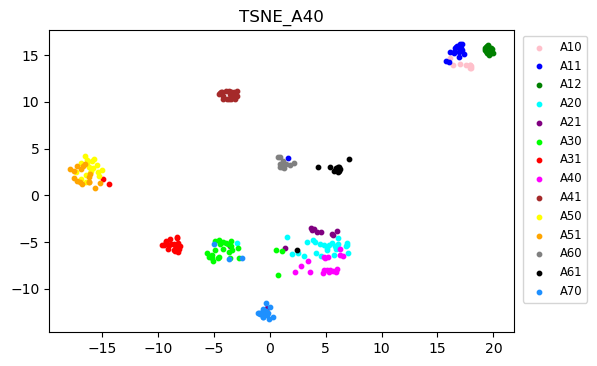

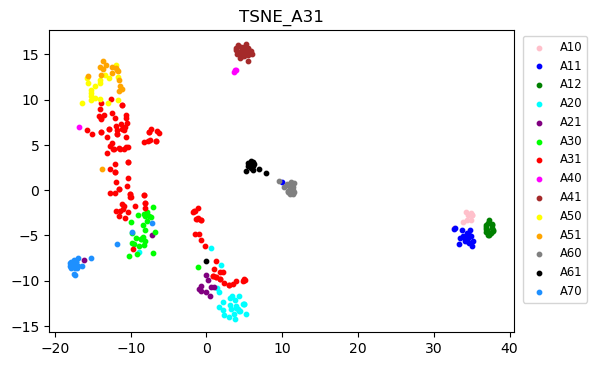

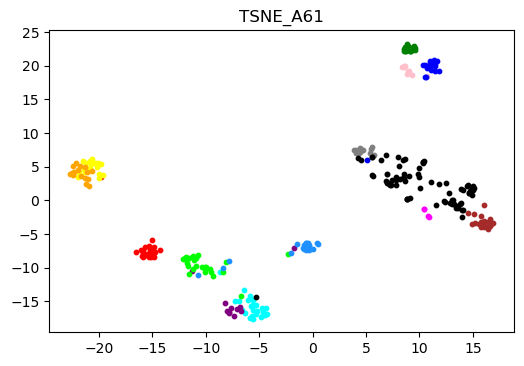

testtime/derivative_objects_new_0221/logits_dict_flat_new.pkl


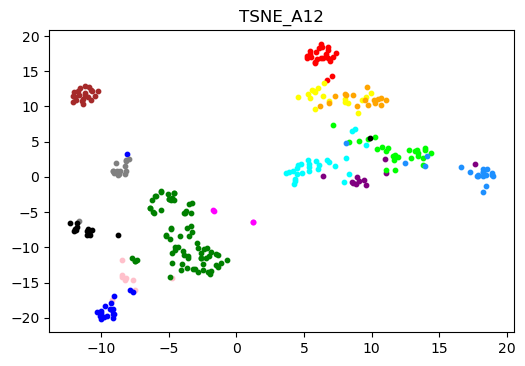

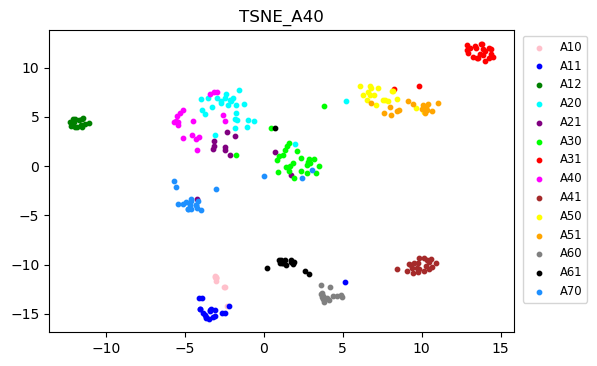

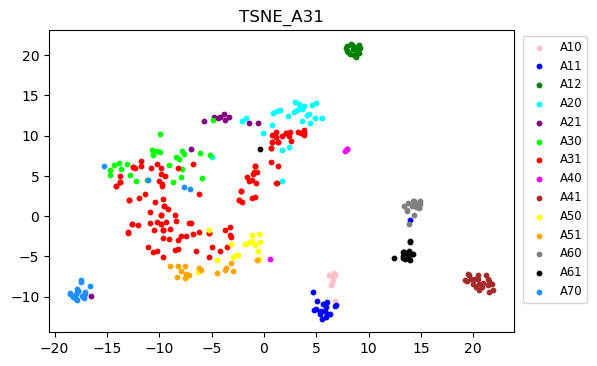

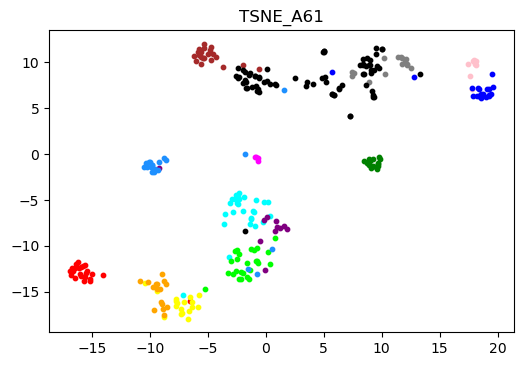

In [4]:
TSNE_for_all(get_logits_dict_data('hier',path),'hier') 
TSNE_for_all(get_logits_dict_data('flat',path),'flat')

## Sensitivity Analysis and visualization
### read all result files

In [5]:
def recursive_read_csv(path, keyword):
    csv_files = {}
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv') and keyword in file:
                file_path = os.path.join(root, file)
                method_name= file.split('_')[0]
                csv_files[method_name] = pd.read_csv(file_path)
    return csv_files

In [6]:
path = './testtime/derivative_objects_new_0221'
all_df = recursive_read_csv(path, '_final')


### define the function to plot the AUROC scores    

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_auroc(dict_key,dict):
    df = dict[dict_key]
    # extract only columns: left_out, model_type, beta, auroc, FPR , TPR, Threshold
    df = df.loc[:, ["left_out", "model_type", "beta", "auroc", "FPR", "TPR", "Threshold"]]

    # only keep row with model_type == hier
    df = df.loc[df["model_type"] == "hier"]
    # split 'left_out' by group based on different values
    groups = df.groupby("left_out")
    order_list = ["A12", "A31", "A61",'A40']
    # use sns boxplot to visualize the auroc values for different 'left_out' and different 'beta's
    plt.figure(dpi=200, figsize=(10, 4))
    sns.boxplot(x="left_out", y="auroc", hue="beta", data=df,order=order_list)
    plt.title(f"Beta Sensitivity Analysis for {dict_key.upper().split('_')[0]}")
    plt.savefig(Path(path)/('sensitivity/'+dict_key.upper()+ '_in_one' +'.png'))
    # put one 'left_out' as one subplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(9, 6),dpi = 200)
    for i, (name, group) in enumerate(groups):
        row = i // 2 # integer division
        col = i % 2 # modulo operation
        sns.boxplot(x="beta", y="auroc", data=group, ax=axes[row][col])
        axes[row][col].set_title(name) # use the dict to get the title
    plt.tight_layout()
    plt.suptitle(f"Beta Sensitivity Analysis for {dict_key.upper().split('_')[0]}",y=1.03)
    # plt.savefig(Path(path)/('sensitivity/'+dict_key.upper()+'.png'))
    plt.show()

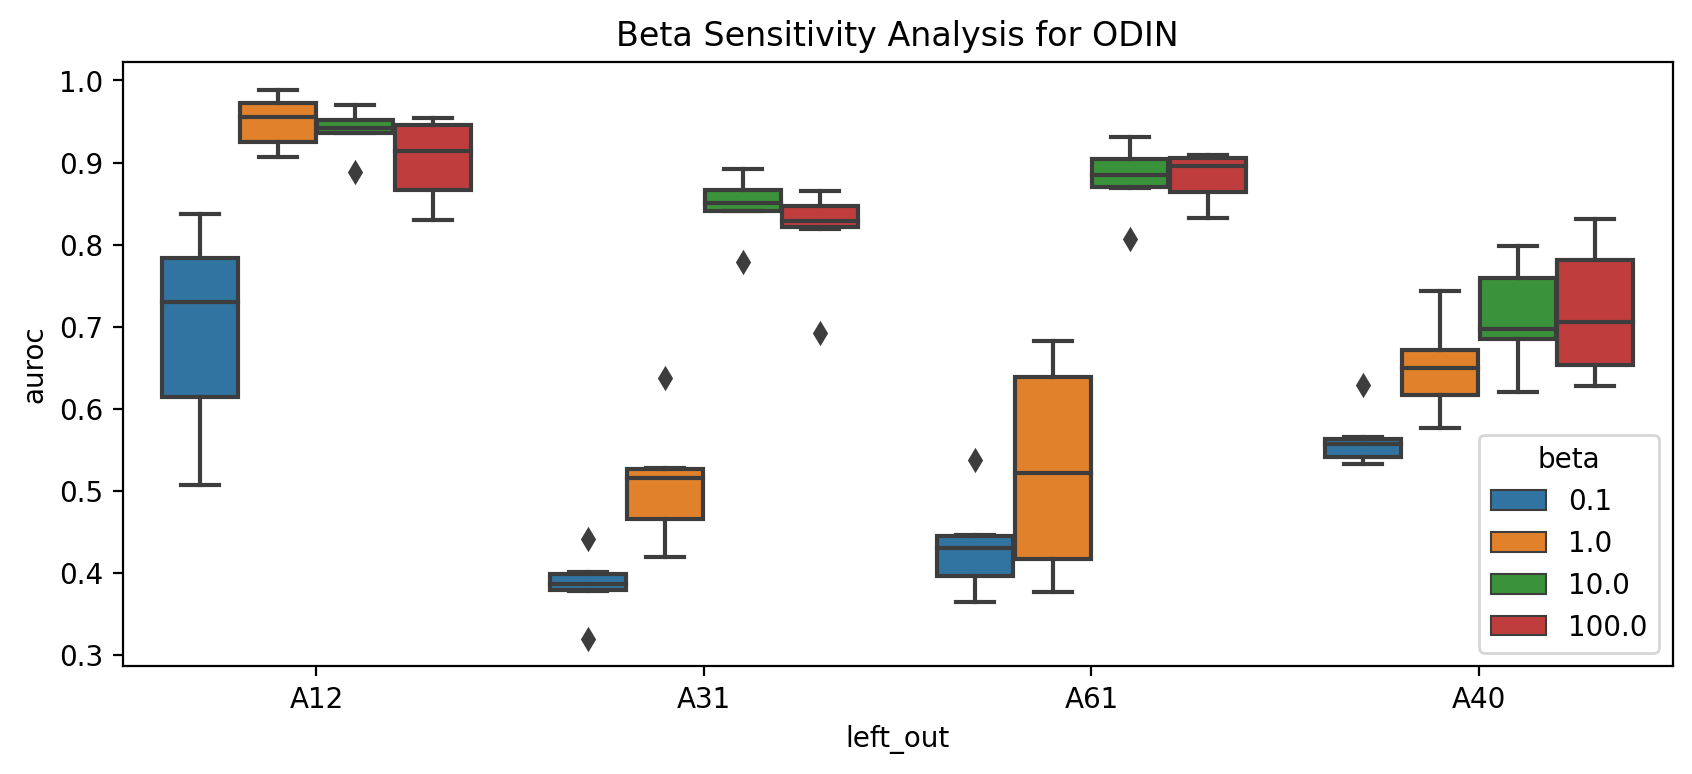

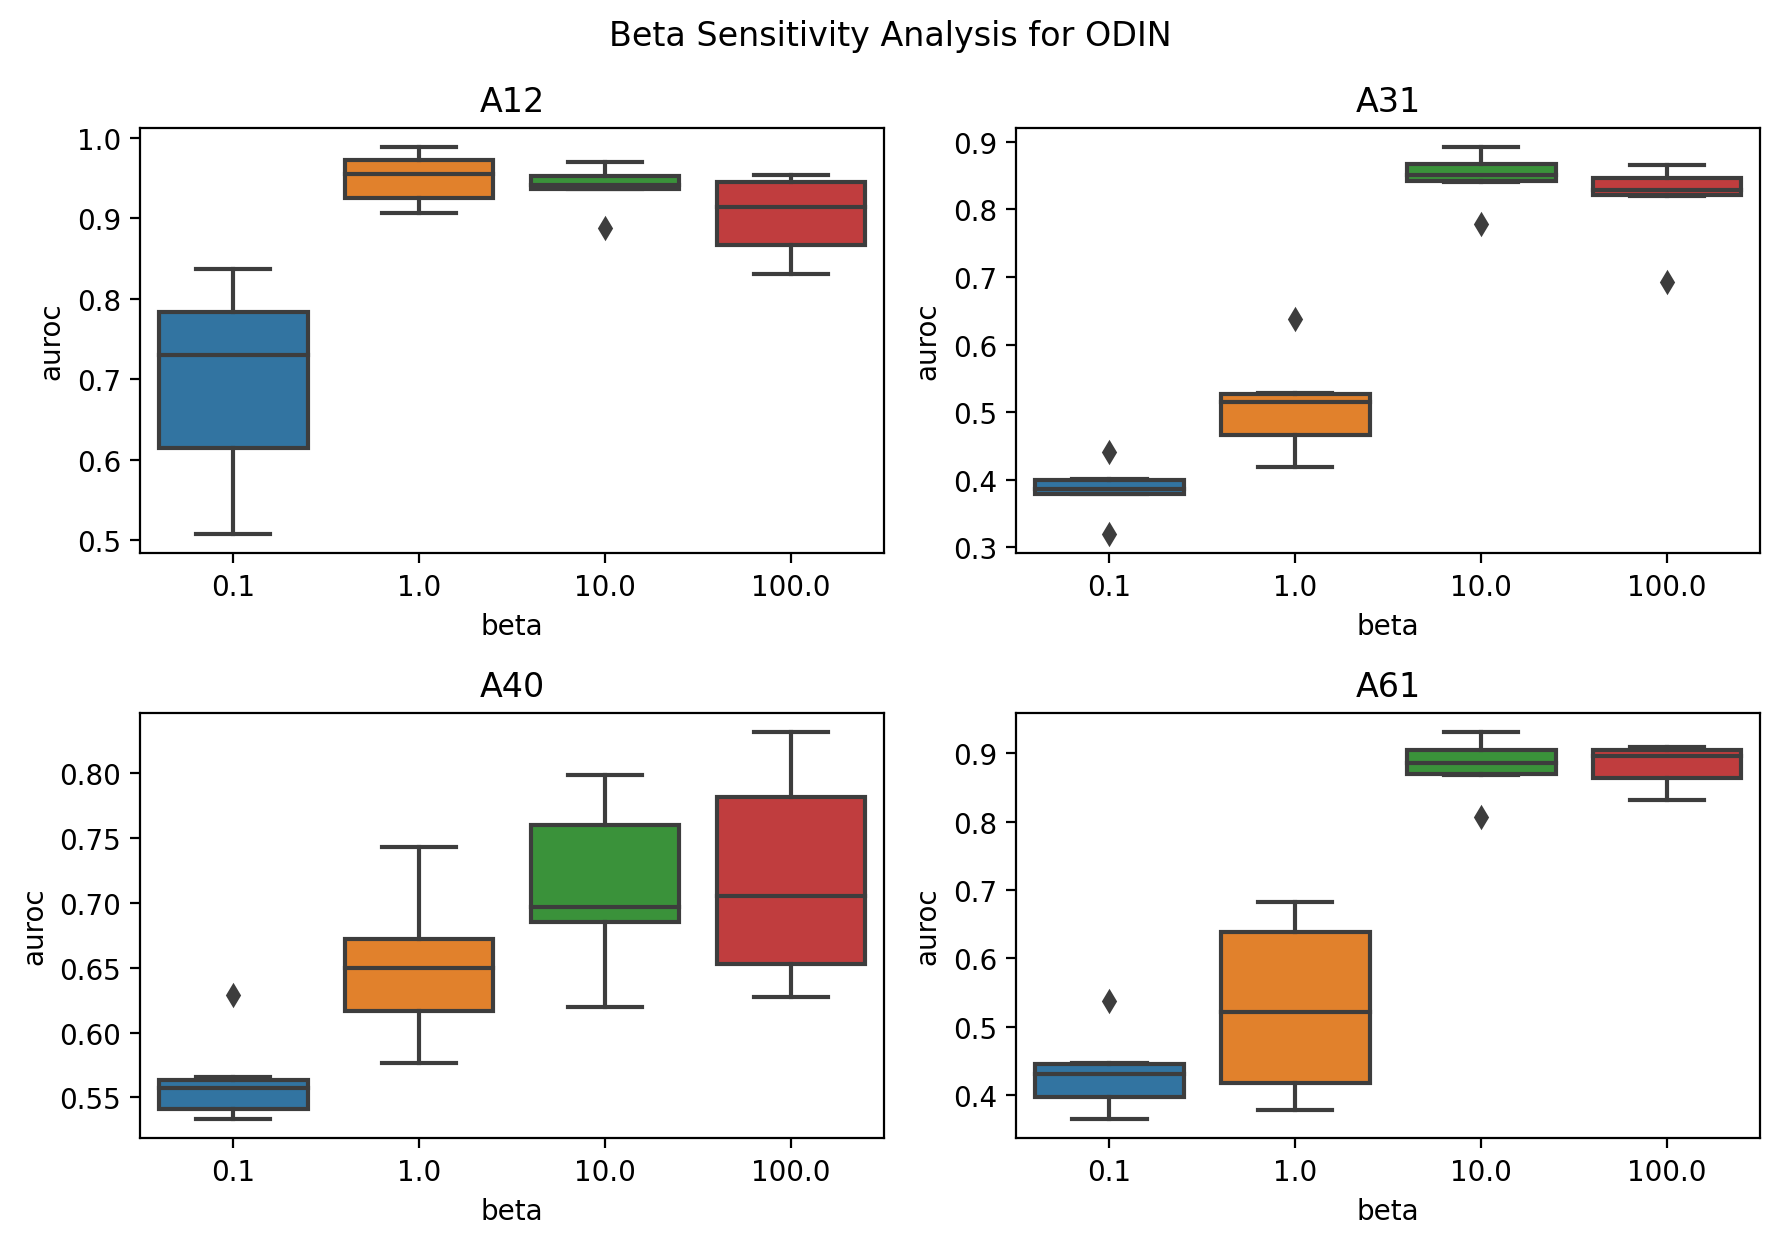

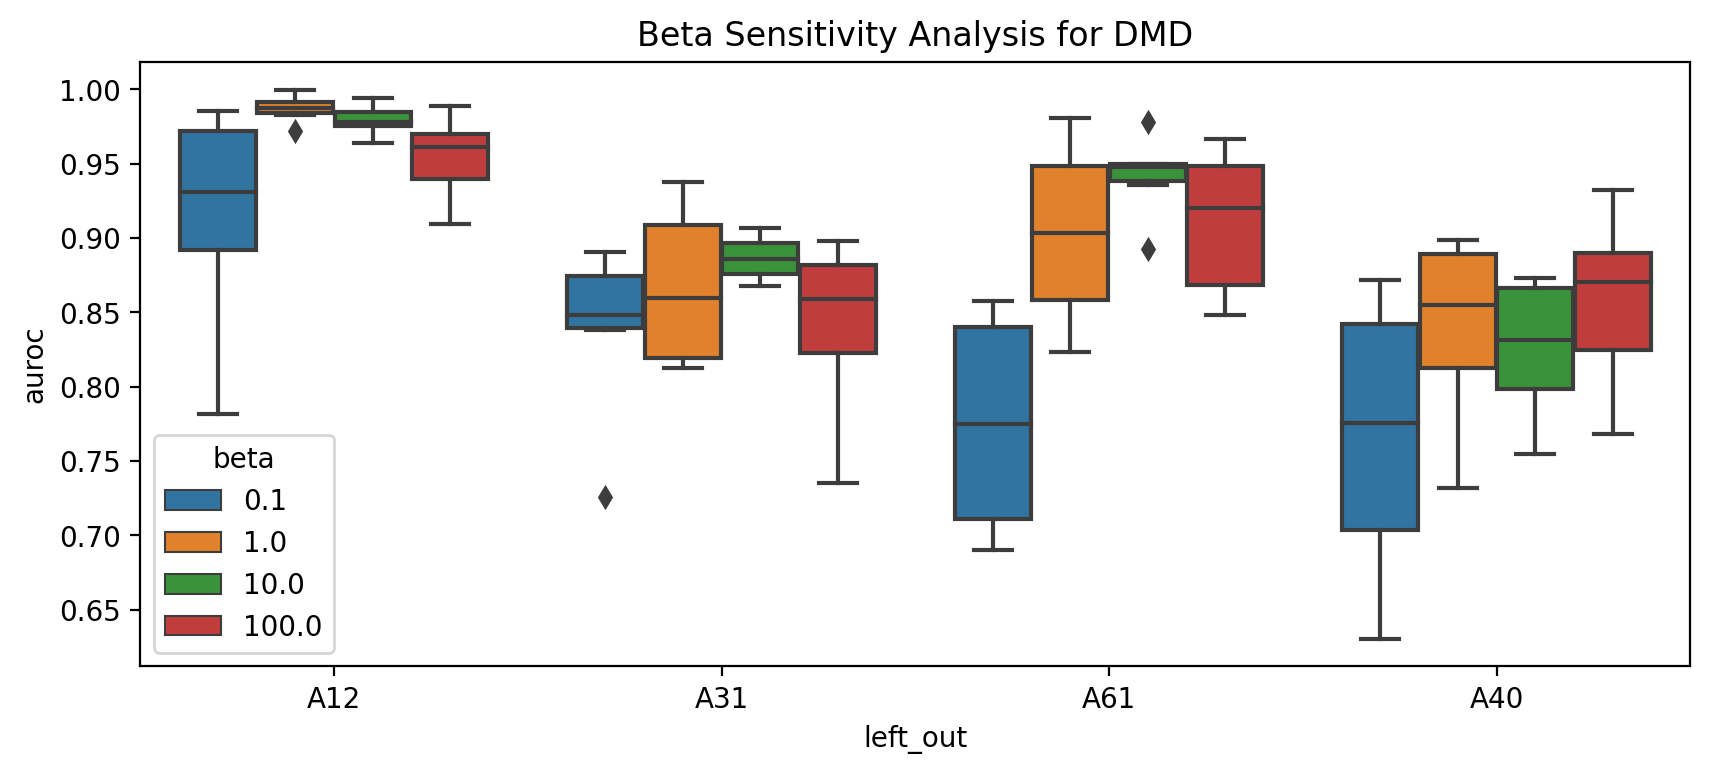

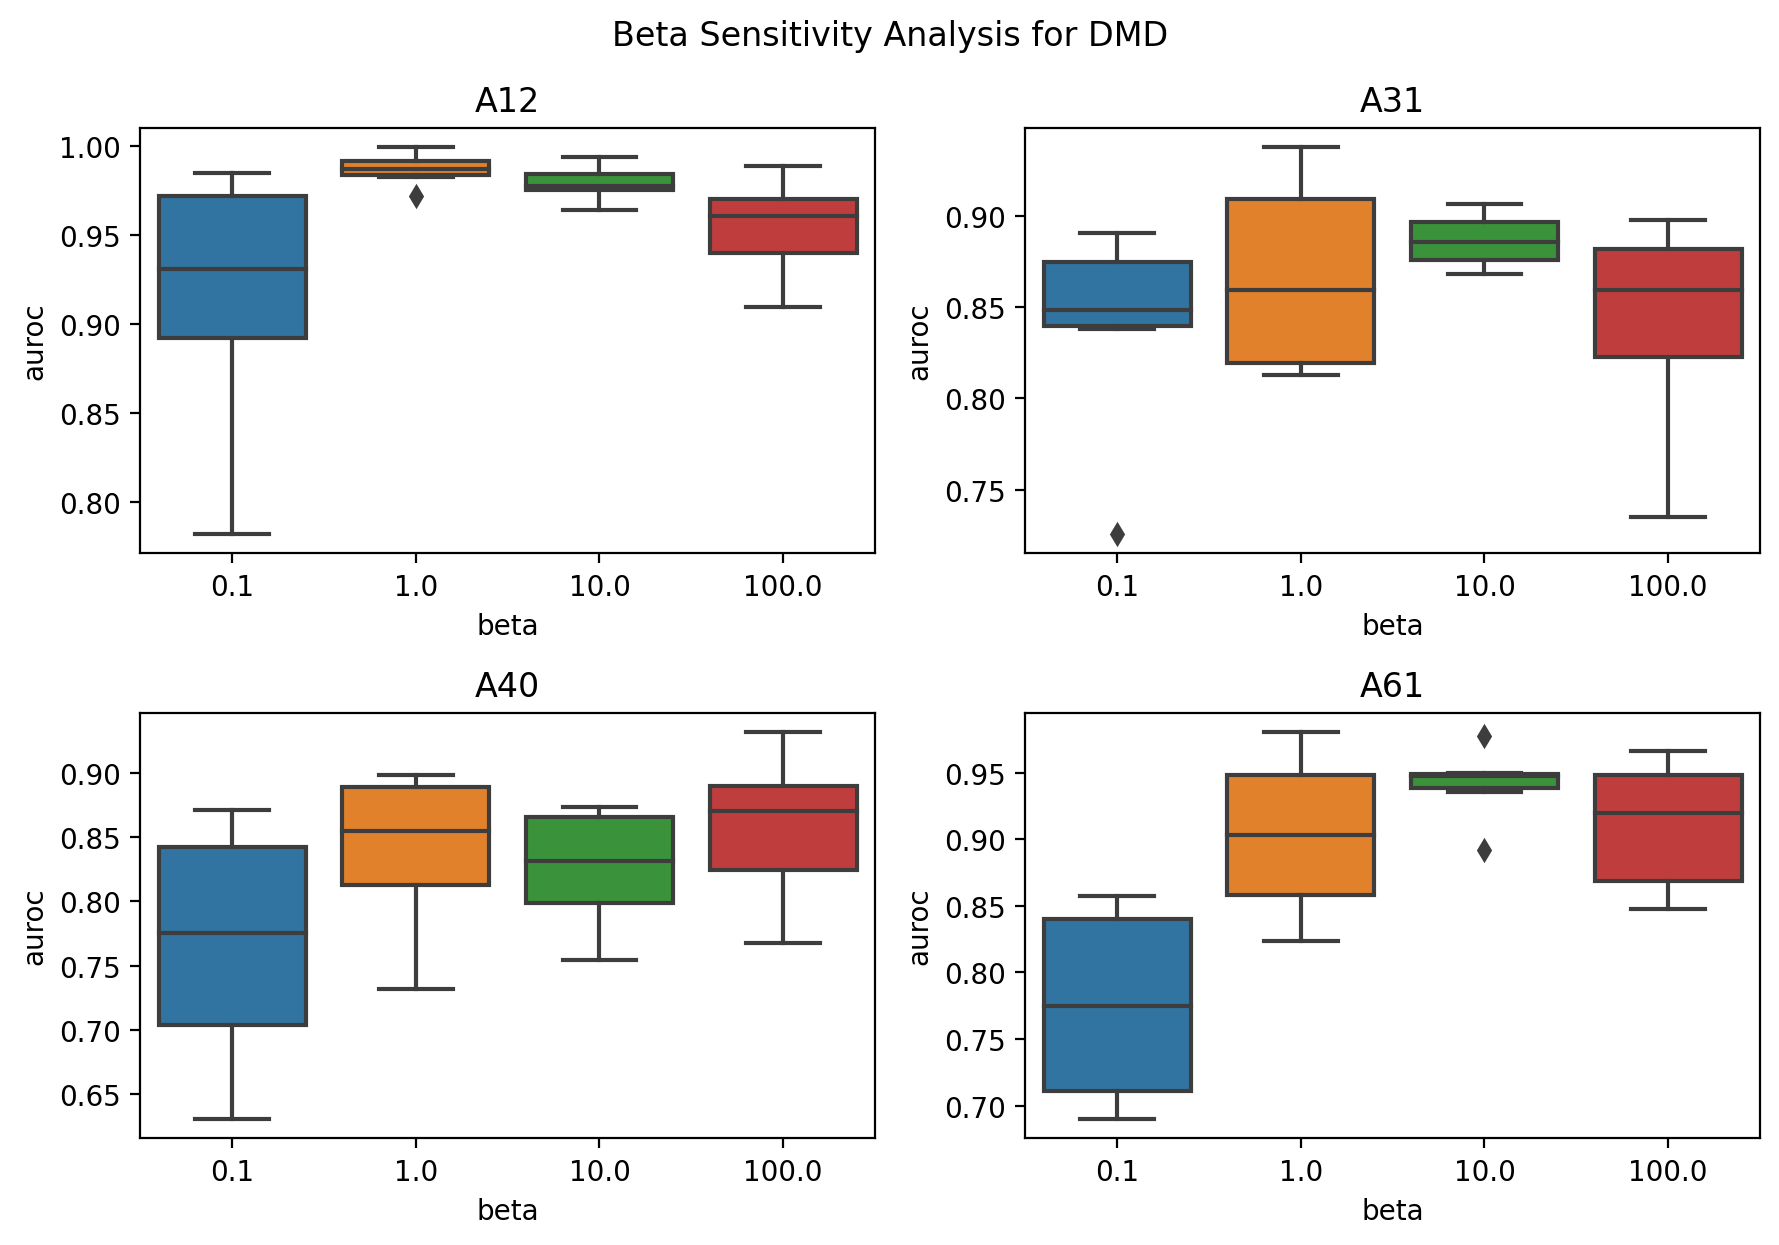

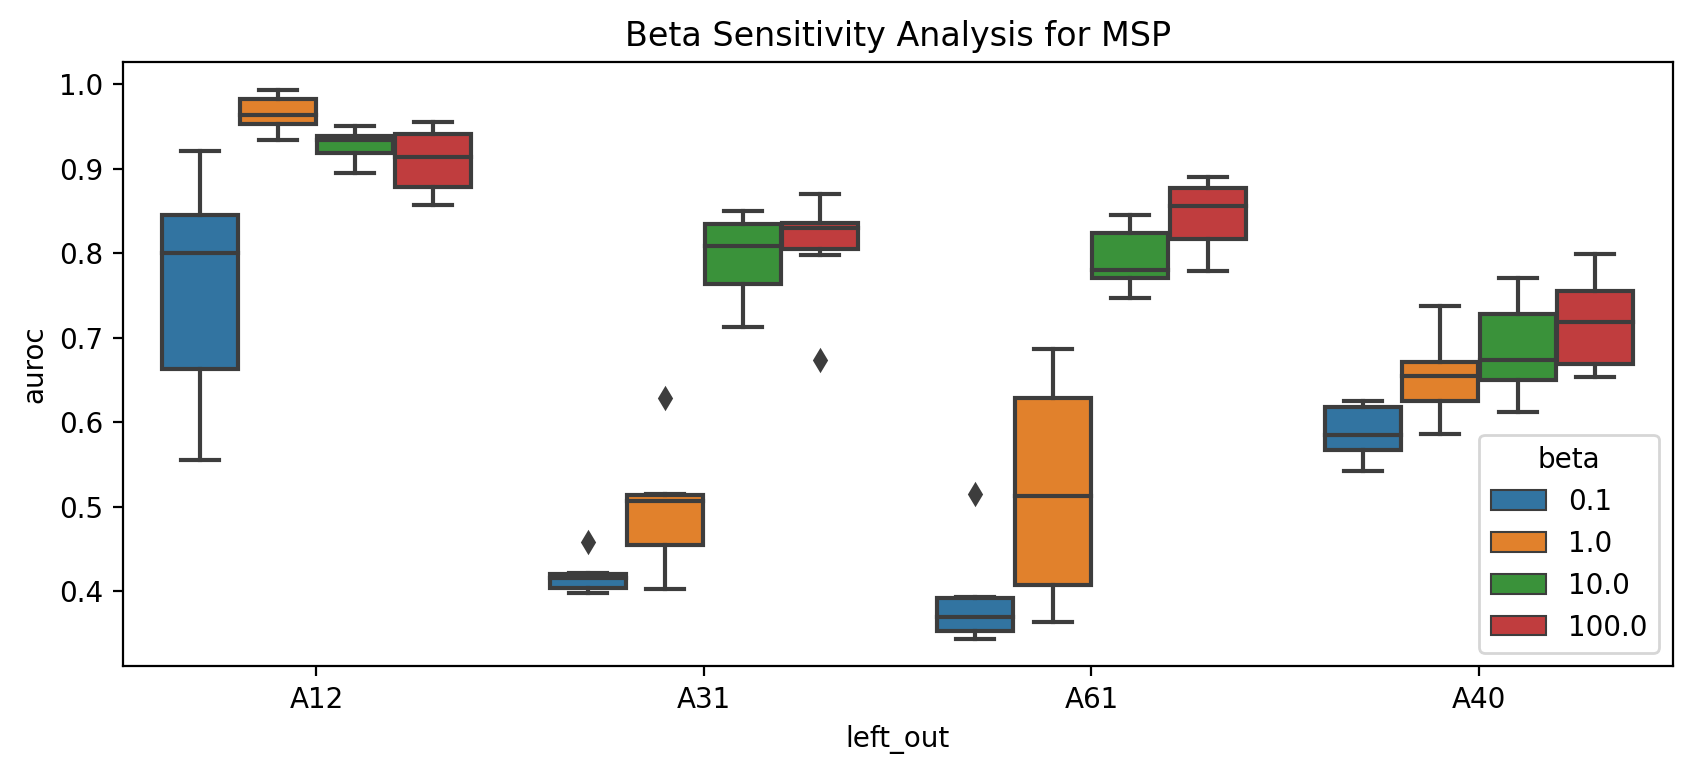

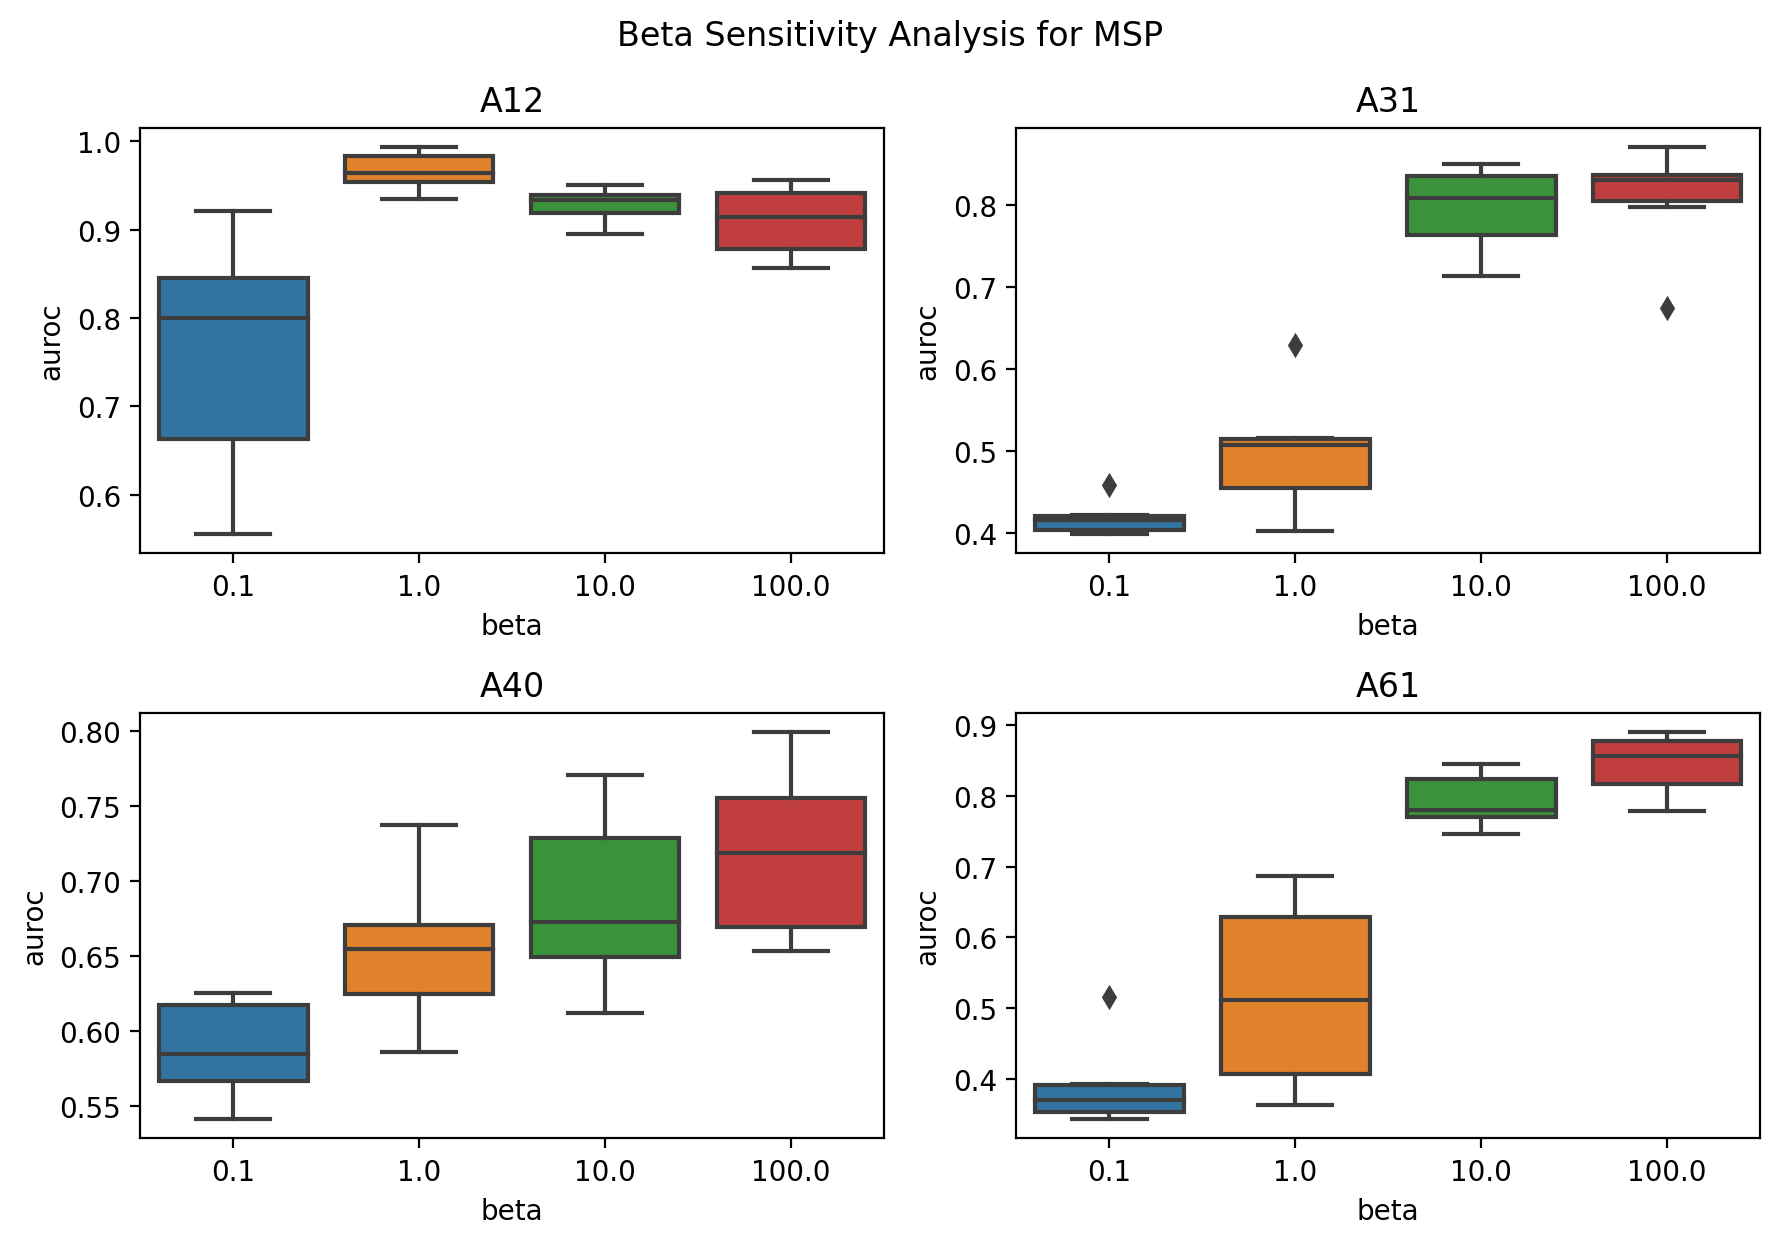

In [8]:
for key in all_df.keys():
    plot_auroc(key,all_df)